# Задание #1: Работа с синтетическими данными

## Импорт данных

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
import sklearn.metrics 


In [ ]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [ ]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty  + l2_term)

In [ ]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

## Сгенерируем знаки инь-янь и концентрические круги

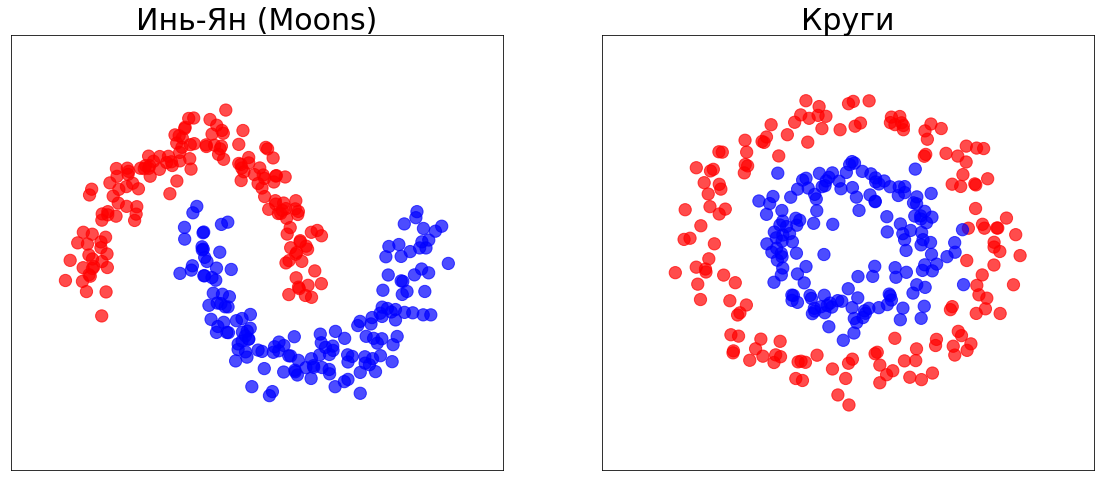

In [ ]:
N = 300 #@param {type:"slider", min:50, max:300, step:25}


def make_binary_clf(N, method = 'line',
                    noises = 0.1,
                    random_state = 42):

    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) *noises
        out = (X, y)
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    
    elif method == 'circles':    
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )

    
    return X,y


fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,method = 'moons'), 
          'Инь-Ян (Moons)')
ax = plt.subplot(1, 3, 3)
plot_data(ax, make_binary_clf(N,method = 'circles'),
          'Круги')




## Проверка различных полиномов 

### Вводим необходимые классы и функции

In [ ]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term   
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))     
    #---------------------------------
    def forward(self, X):     
        return self.sigmoid(np.dot(X, self.weights))   
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1   
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    #---------------------------------
    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat 
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    #---------------------------------
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);
        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape) 
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

**Введем данные для классификации**

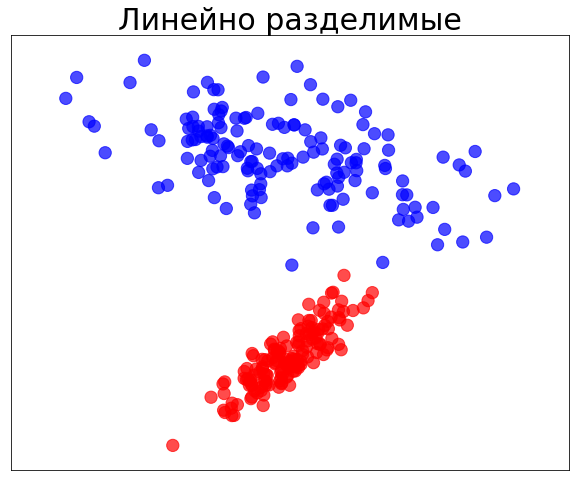

In [ ]:
X,y = make_binary_clf(N,method = 'line')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X, y), 
          'Линейно разделимые')

**Проведем тестирование без регуляризации**

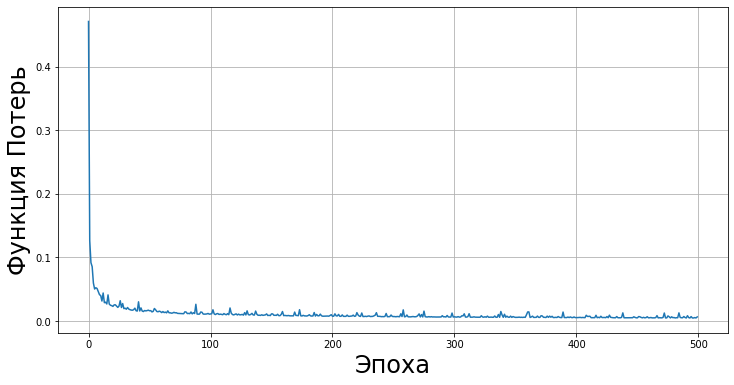

1.0 1.0
True Positives:1.0000	True Negatives:1.0000
False Positives:0.0000	False Negatives:0.0000
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [ ]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

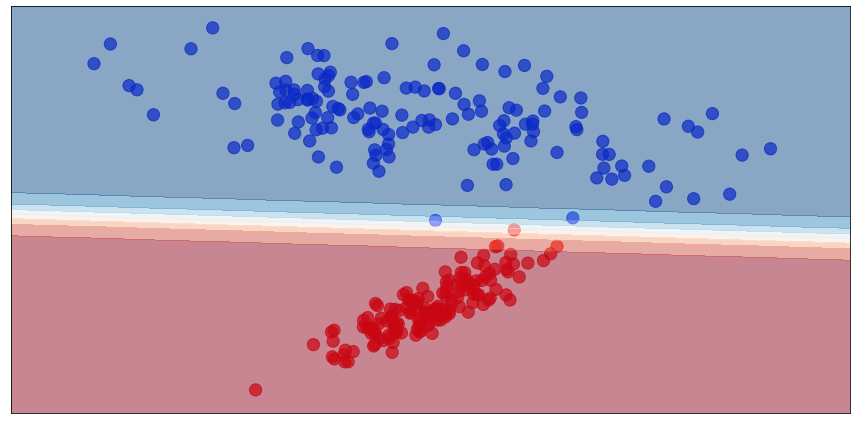

In [ ]:
regr.plot_desicion_function(X,y)

Данные довольно точные. Рассмортим другие методы.

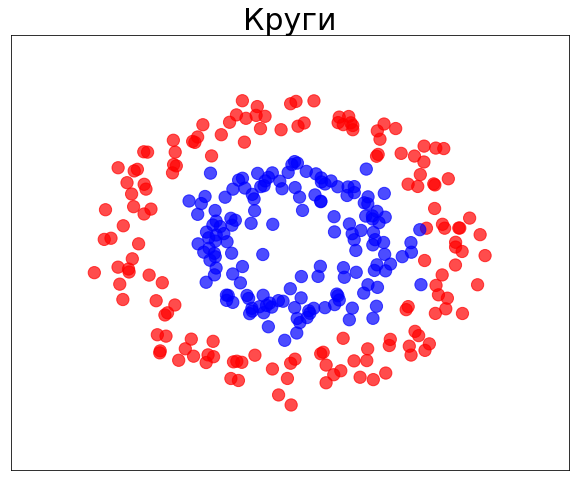

In [ ]:
X,y = make_binary_clf(N,method = 'circles')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Круги')

**Введем функции введения полинома**

In [ ]:
def to_polynom(X, order = 2):
    order_range = range(order, order+1,1)
    out = np.copy(X) 
    for i in order_range:
        out = np.hstack([out, np.power(X,i)])
    return out

**Полином 2го уровня**

In [ ]:
X_poly   = to_polynom(X, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)


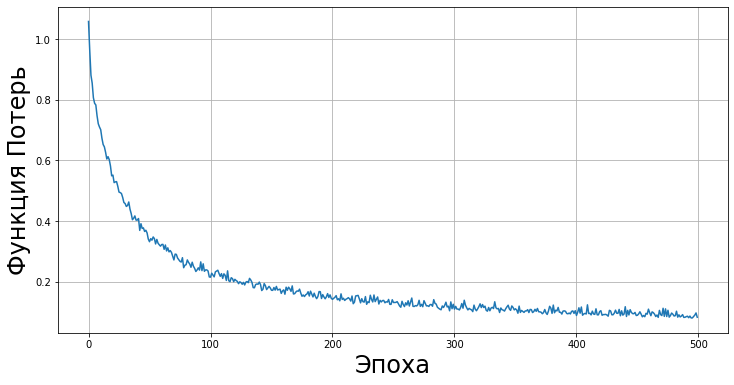

1.0 0.9952380952380953
True Positives:1.0000	True Negatives:1.0000
False Positives:0.0000	False Negatives:0.0000
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


In [ ]:
regr = LogisticRegression(learning_rate=0.15,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

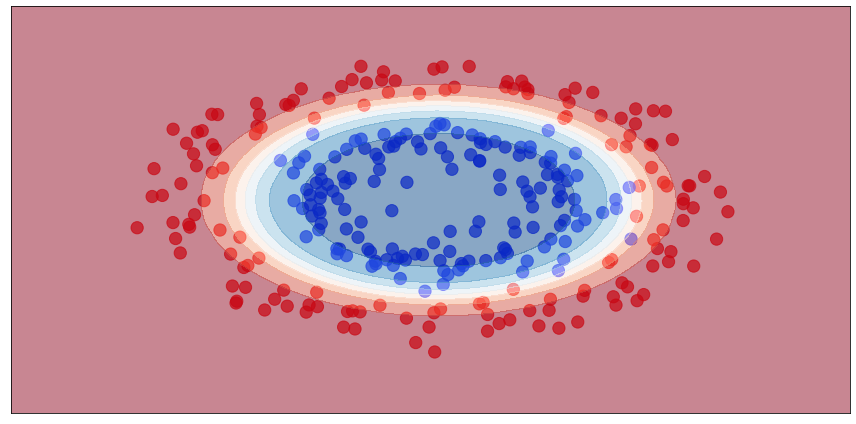

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)


**Полином 3го уровня**

In [ ]:
X_poly   = to_polynom(X, order = 3)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)


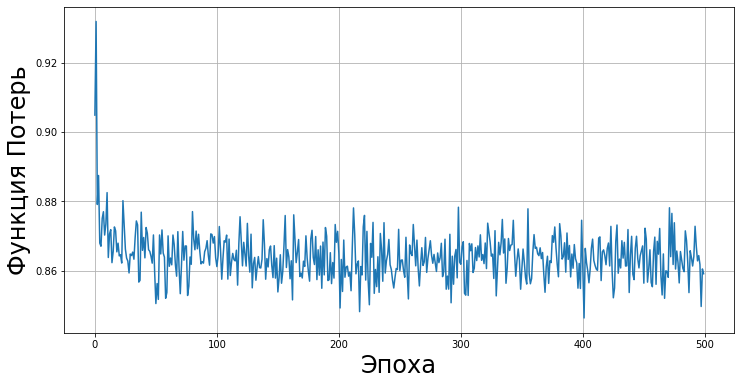

0.4111111111111111 0.5095238095238095
True Positives:0.0000	True Negatives:0.4157
False Positives:1.0000	False Negatives:0.5843
Accuracy:0.4111
Recall:0.0000	Precision:0.0000
f1 measure:0.0000


In [ ]:
regr = LogisticRegression(learning_rate=0.15,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

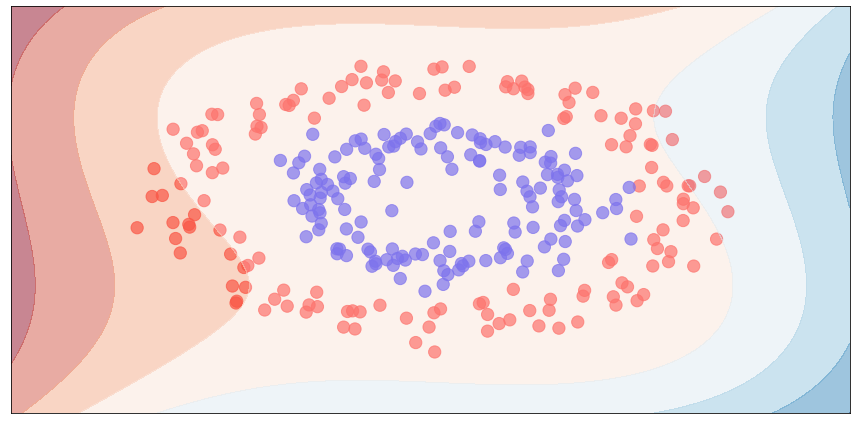

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 3)

**Полином 4го уровня**

In [ ]:
X_poly   = to_polynom(X, order = 4)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

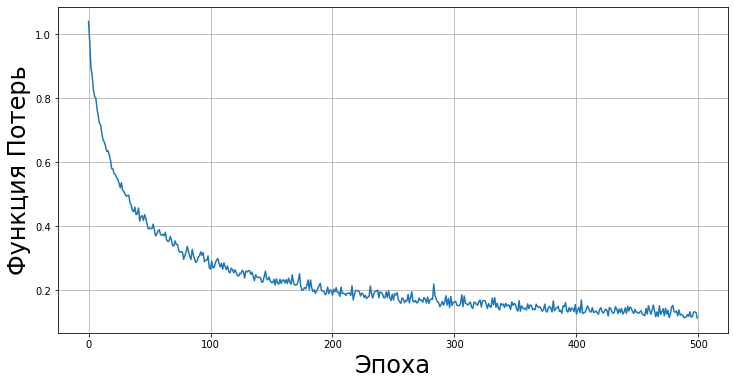

0.9777777777777777 0.9666666666666667
True Positives:0.9630	True Negatives:1.0000
False Positives:0.0370	False Negatives:0.0000
Accuracy:0.9778
Recall:1.0000	Precision:0.9630
f1 measure:0.9811


In [ ]:
regr = LogisticRegression(learning_rate=0.15,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

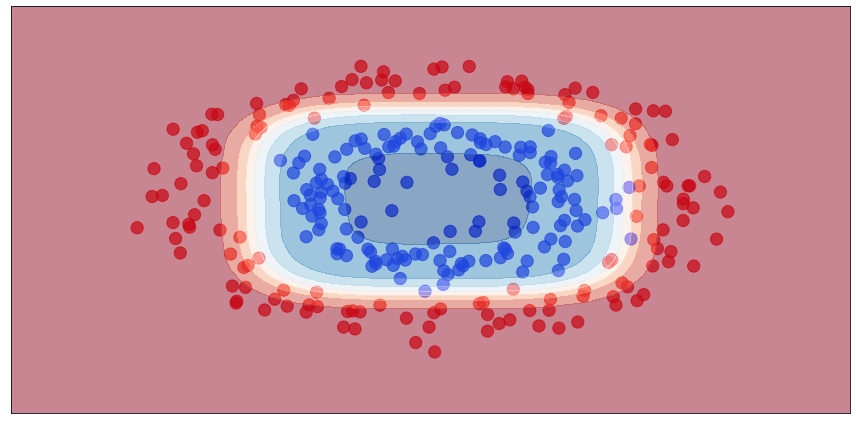

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 4)

**Вывод**

Исходя из приведенных выше данных и их визуализации, полином третьего порядка привел самые нестабильные результаты, высвечивая 0 среди True Positive параметров. Полином второго порядка оказался самым точным, выражаясь единицей в таких метриках как Accuracy, Recall, Precision. Рассмотрим полиноминальные функции на последнем методе и оценим точность разноуровневых полиномов.

**Инь-янь**

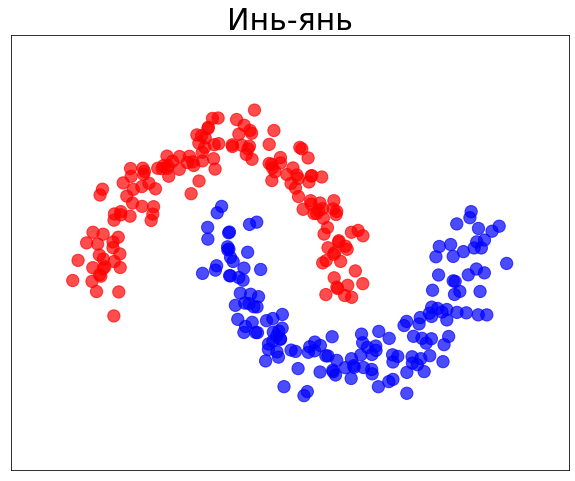

In [ ]:
X,y = make_binary_clf(N,method = 'moons')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Инь-янь')

**Полином 2го уровня**

In [ ]:
X_poly   = to_polynom(X, order = 2)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

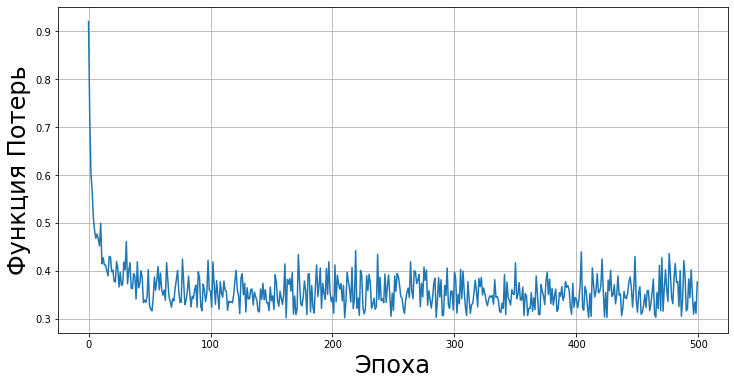

0.9111111111111111 0.8666666666666667
True Positives:0.9231	True Negatives:0.8947
False Positives:0.0769	False Negatives:0.1053
Accuracy:0.9111
Recall:0.9231	Precision:0.9231
f1 measure:0.9231


In [ ]:
regr = LogisticRegression(learning_rate=0.15,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

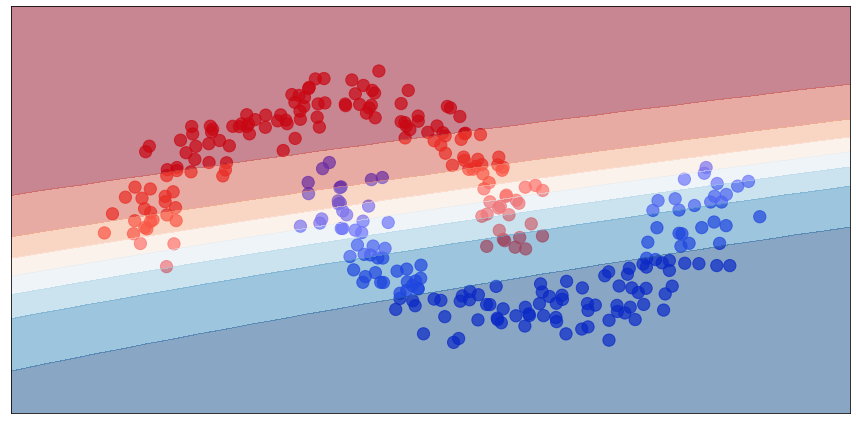

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

Данные уже отображают меньшую точность. Все потому, что невозможно провести прямую линию для разделения двух классификаций. Попробуем другие полиномы.

**Полином 3го уровня**

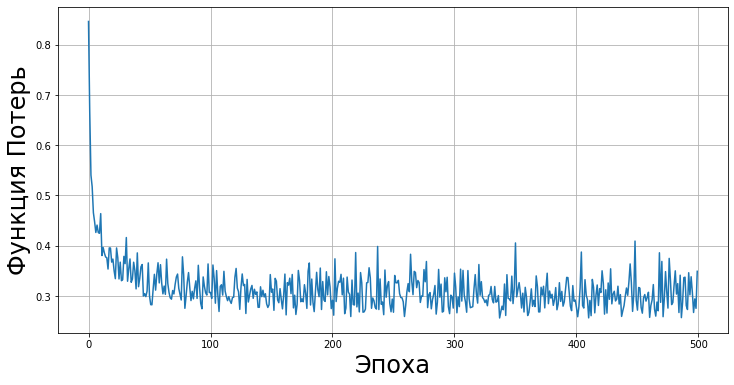

0.9222222222222223 0.8904761904761904
True Positives:0.9412	True Negatives:0.8974
False Positives:0.0588	False Negatives:0.1026
Accuracy:0.9222
Recall:0.9231	Precision:0.9412
f1 measure:0.9320


In [ ]:
X_poly   = to_polynom(X, order = 3)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

regr = LogisticRegression(learning_rate=0.15,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

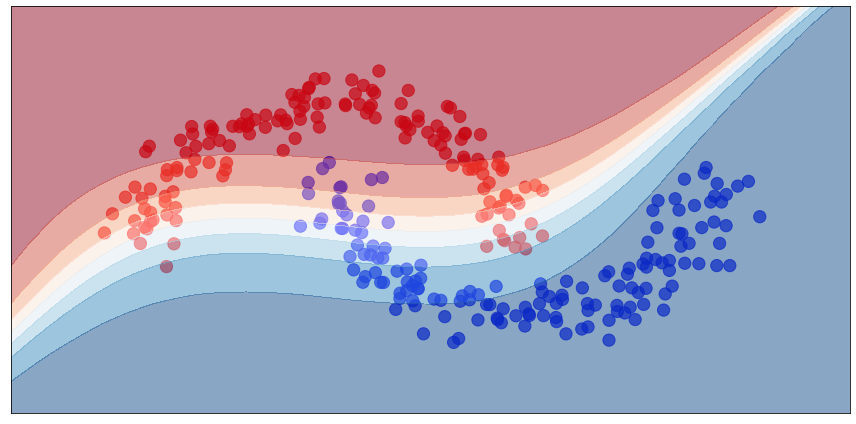

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 3)

Теперь линии пытаются изогнуться под классификации. Результат лучше предыдущего. Третий полином выигрывает в данном методе.

**Полином 4го уровня**

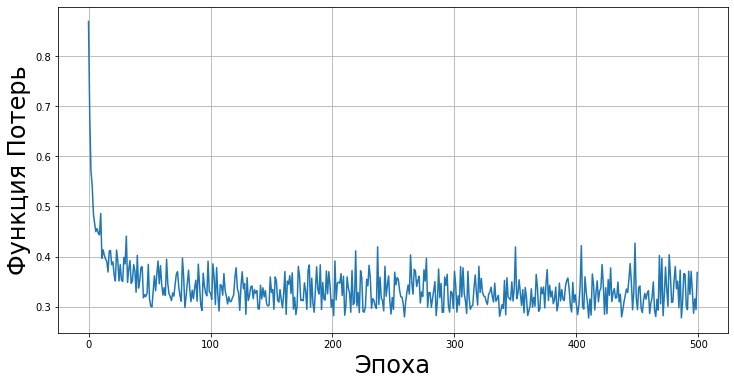

0.9222222222222223 0.8761904761904762
True Positives:0.9412	True Negatives:0.8974
False Positives:0.0588	False Negatives:0.1026
Accuracy:0.9222
Recall:0.9231	Precision:0.9412
f1 measure:0.9320


In [ ]:
X_poly   = to_polynom(X, order = 4)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

regr = LogisticRegression(learning_rate=0.15,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

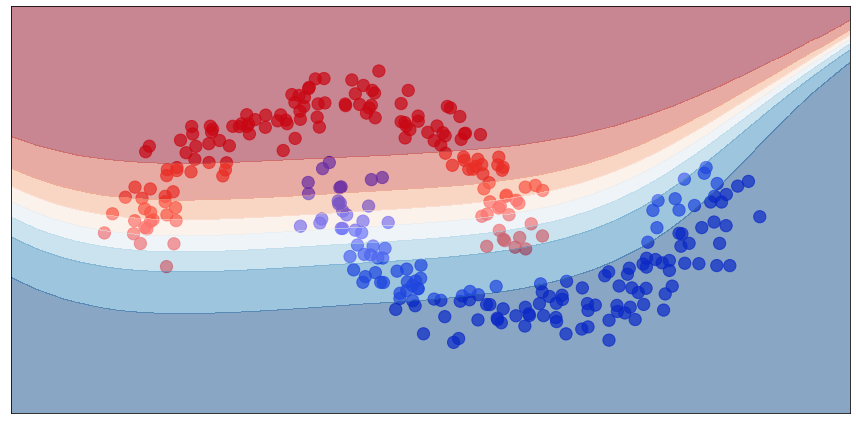

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 4)

Результаты менее точные, чем в предыдущем. Дальнейшая точность результатов зависит от других параметров.

# Задание #2: Работа с cars_moldova

## Import библиотек

In [ ]:
import pandas as pd
from google.colab import files 

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Считываем файл в DataFrame



In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Files/cars_moldova_cat_num.csv', delimiter = ',')
df.tail()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),km_year
32069,42,88,2016,10,88000.0,1800.0,4,1,11500.0,14666.666667
32070,19,53,2002,3,225000.0,1800.0,3,0,4400.0,11250.000000
32071,6,77,2015,11,89000.0,1500.0,0,0,7000.0,12714.285714
32072,22,10,2006,1,370000.0,2000.0,0,0,4000.0,23125.000000
32073,32,62,2006,6,300000.0,1500.0,0,0,4000.0,18750.000000


In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

## Логистическая регрессия

Предсказания типа трансмиссии автомобилей на вторичном рынке Молдавии

Введем необходимые классы и функции

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z)) 

In [ ]:
sigmoid(0.25)

0.5621765008857981

In [ ]:
sigmoid_derivative(-3)

0.04517665973091214

In [ ]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6)):
        plt.figure(figsize = figsize)
        plt.plot(self.cost,'-*')
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [ ]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)* self.l1_penalty + l2_term)

In [ ]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 threshold = 0.5,
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term 
    
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    #---------------------------------
    def forward(self, X):        
        return self.sigmoid(self.weights.dot(X.T))
    
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        
        if self.threshold:
            return self.to_class(yhat)
        else:
            return yhat
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.0f'%(tp), end = '\t')
        print('False Positives:%.0f'%(fp))
        print('False Negatives:%.0f'%(fn), end = '\t')
        print('True Negatives:%.0f'%(tn))
        
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

Запишим данные для классификации.

In [ ]:
X = df[num_columns].values 
y = df["Transmission"].values
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4
22446,0.64,0.479896,0.353333,0.046092,0.251134
22447,0.74,0.465893,0.479167,0.077144,0.331520
22448,0.70,0.572360,0.333333,0.058106,0.356492
22449,0.70,0.581916,0.375000,0.046593,0.362475
22450,0.24,0.579916,0.000000,0.008016,0.147012


Проведем тестирование без регуляризации 

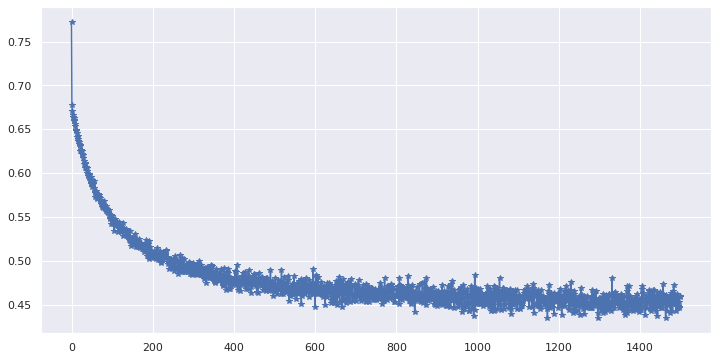

train Accuracy: 0.8040; test Accuracy: 0.8112
True Positives:3283	False Positives:730
False Negatives:1087	True Negatives:4523
Accuracy:0.8112
Recall:0.7513	Precision:0.8181
f1 measure:0.7833


In [ ]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

Посмотрим веса

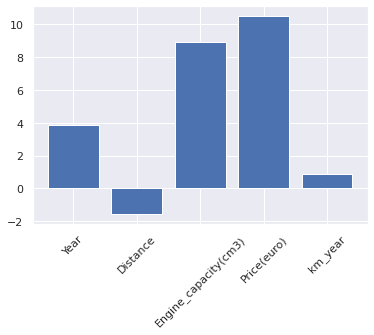

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

**Вывод**: исходя из весов и функции потерь, данные довольно точны (хотя могло быть и лучше), и не очень релевантными категориями для целевого параметра являются дистанция и км/ч. 

Проведем тест с регуляризацией L2

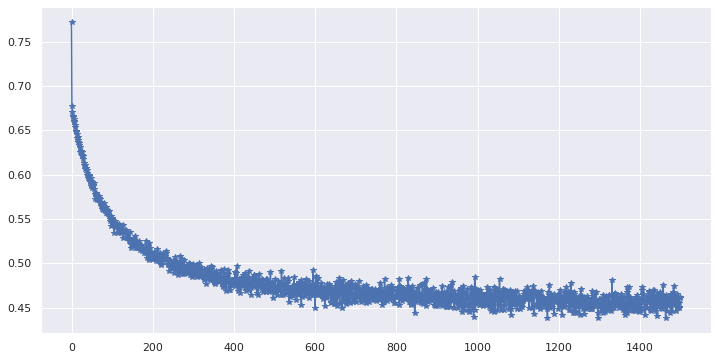

train Accuracy: 0.8034; test Accuracy: 0.8112
True Positives:3270	False Positives:717
False Negatives:1100	True Negatives:4536
Accuracy:0.8112
Recall:0.7483	Precision:0.8202
f1 measure:0.7826


In [ ]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l2_penalty = 0.0001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

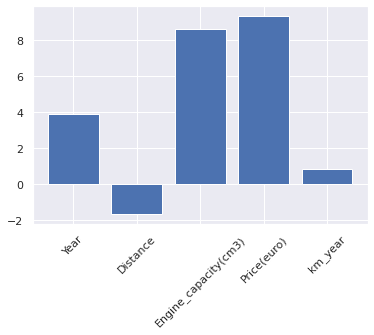

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с L1 регуляризацией

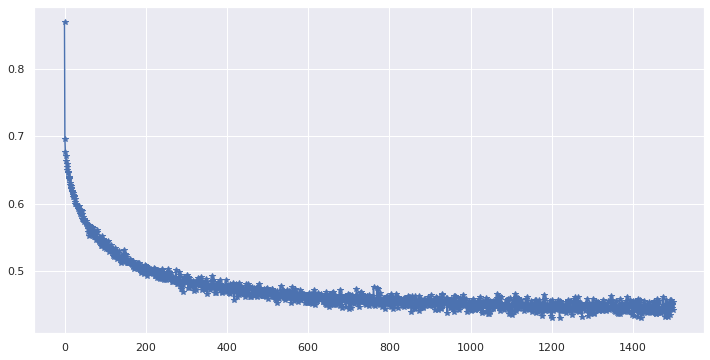

train Accuracy: 0.8185; test Accuracy: 0.8196
True Positives:3297	False Positives:636
False Negatives:1108	True Negatives:4625
Accuracy:0.8196
Recall:0.7485	Precision:0.8383
f1 measure:0.7908


In [150]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

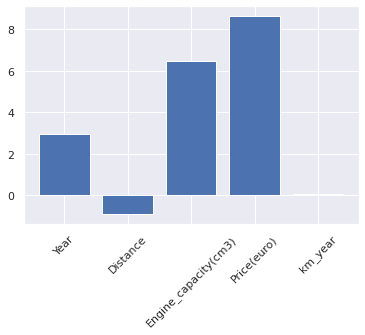

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

**Вывод**: данные практически не изменились, за исключением малого повышения значения точности как у тренировочной, так и тестовой выборок.

Эластичная регрессия

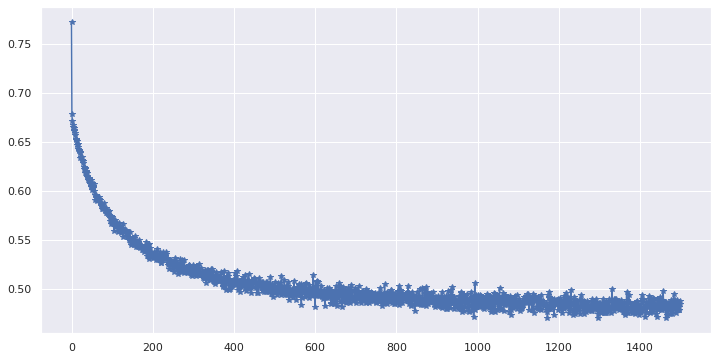

train Accuracy: 0.8048; test Accuracy: 0.8160
True Positives:3196	False Positives:597
False Negatives:1174	True Negatives:4656
Accuracy:0.8160
Recall:0.7314	Precision:0.8426
f1 measure:0.7830


In [ ]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

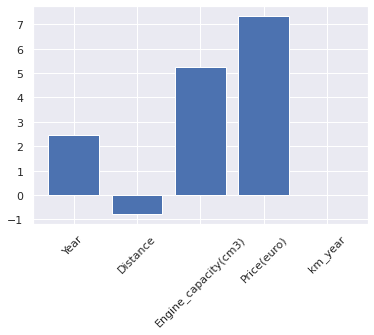

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Считаем данные с one-hot encoding для дальнейшего анализа

In [ ]:
df_hot = pd.read_csv('drive/MyDrive/Colab Notebooks/Files/cars_moldova_onehot.csv')

df_hot.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,km_category_Big,km_category_Medium,km_category_Small
0,41,536,2011,4,195000.0,1800.0,2,1,7750.0,11,17727.272727,0,1,0
1,33,360,2014,11,135000.0,1500.0,0,0,8550.0,8,16875.000000,0,1,0
2,33,420,2012,11,110000.0,1500.0,0,0,6550.0,10,11000.000000,0,1,0
3,28,137,2006,11,200000.0,1600.0,3,0,4100.0,16,12500.000000,0,1,0
4,23,726,2000,5,300000.0,2200.0,0,0,3490.0,22,13636.363636,0,1,0


In [ ]:
numcolumns = []
for i in df_hot.columns:
  if not i == 'Transmission':
    numcolumns += [i]

print('num_columns =', numcolumns)

num_columns = ['Make', 'Model', 'Year', 'Style', 'Distance', 'Engine_capacity(cm3)', 'Fuel_type', 'Price(euro)', 'Age', 'km_year', 'km_category_Big', 'km_category_Medium', 'km_category_Small']


In [ ]:
X = df_hot[numcolumns].values 
y = df_hot["Transmission"].values
features_names = df_hot[numcolumns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12
22549,0.977273,0.455484,0.40,0.363636,0.011012,0.291667,0.8,0.006513,0.60,0.005179,0.0,0.0,1.0
22550,0.931818,0.691613,0.74,0.909091,0.208921,0.270833,0.4,0.061112,0.26,0.297166,0.0,1.0,0.0
22551,0.136364,0.350968,0.84,0.272727,0.155127,0.270833,0.0,0.078146,0.16,0.343601,0.0,1.0,0.0
22552,0.295455,0.500645,0.84,0.363636,0.219922,0.229167,0.8,0.066132,0.16,0.487865,1.0,0.0,0.0
22553,0.818182,0.855484,0.94,0.909091,0.049905,0.375000,0.8,0.251503,0.06,0.248497,0.0,1.0,0.0


Проведем тестирование без регуляризации

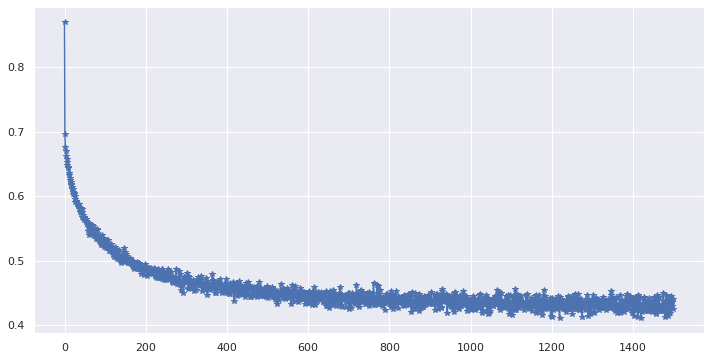

train Accuracy: 0.8215; test Accuracy: 0.8203
True Positives:3314	False Positives:646
False Negatives:1091	True Negatives:4615
Accuracy:0.8203
Recall:0.7523	Precision:0.8369
f1 measure:0.7923


In [ ]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

Посмотрим веса

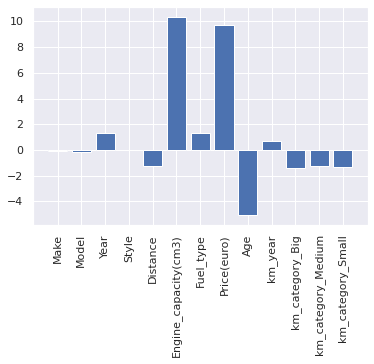

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 'vertical' );

Среди категориальных значений, переформированных в числовые с помощью one-hot encoding, важными являются модель и fuel type. Среди числовых это, безусловно, цена и емкость двигателя.

Самыми неважными категориальными признаками являются маленький/средний/большой пробеги, что довольно логично.